# TMDB Movie Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
> Looking to investigate TMDB movie dataset particularly trying to figure out what properties are associated with movies having high revenue (and profit - extended) and what properties leads to higher ratings on movies.

In [38]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<a id='wrangling'></a>
## Data Wrangling

> The data set, `tmdb-movies.csv`, contains information of about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue

### General Properties

In [39]:
df = pd.read_csv('tmdb-movies.csv')
df.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


> Seems the dataset has about 21 columns. 
>
> Also seems the some columns have rows with string concatenated with `|`.
>
> Let's view complete column list and see their data types aswell.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

> We have `10866` rows in dataset (no need for `df.shape`) a couple of floats, strings and integers. We can see some `nan` values aswell, will look at this below.
>
> We have 2 id columns `id` and `imdb_id`, would probably just need one of them. I would check later if I can uniquely identify rows with both before droping.
>
> The columns `budget_adj` and `revenue_adj` are the `budget` and `revenue` of the movies adjusted for inflation in terms of 2010 dollars. Would be using those instead of the `budget` and `revenue` columns.
>
> Lets look at the `nan` values clearly.

In [41]:
nan_vals = df.isnull().sum()
nan_vals.where(nan_vals > 0).dropna()

imdb_id                   10.0
cast                      76.0
homepage                7930.0
director                  44.0
tagline                 2824.0
keywords                1493.0
overview                   4.0
genres                    23.0
production_companies    1030.0
dtype: float64

> Lets look at the `homepage`, `tagline`, `keywords` and `overview` a little closer.

In [42]:
df[['homepage', 'tagline', 'keywords', 'overview']].head()

,homepage,tagline,keywords,overview
0,http://www.jurassicworld.com/,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...
1,http://www.madmaxmovie.com/,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...
2,http://www.thedivergentseries.movie/#insurgent,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...
3,http://www.starwars.com/films/star-wars-episod...,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...
4,http://www.furious7.com/,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...


> Although each of this has importance when discovering a movie, I don't think I would be doing much with them so would be dropping them. We will also be dropping `imdb_id` and will be using `id` column instead.
>
> For `nan` values in `cast`, `director`, `genres` and `production_companies` we will handle those later. In the mean time, let's get some summary statistics

In [43]:
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


> More than `50 percent` of the data has a budget and revenue of `0`. We can also see a movie with `0` `runtime`. Hmmm, this might be cases of incorrect entry or not having the information. Let's get closer.

C:\Users\Mike\AppData\Local\Temp/ipykernel_9808/116877306.py:2: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(pad=20);


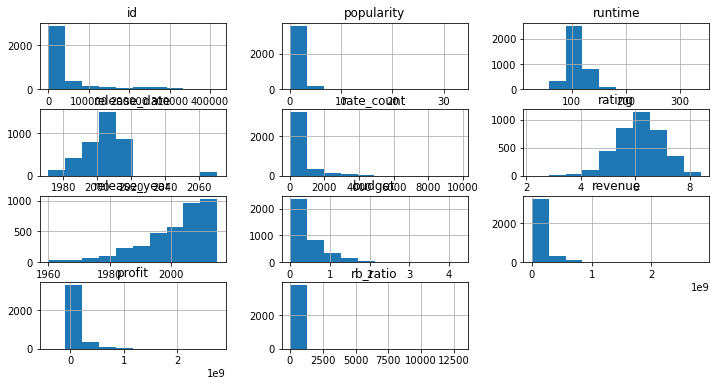

In [103]:
df.hist(figsize=(12, 6))

In [44]:
df.query('budget == 0 and revenue == 0').head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
74,347096,tt3478232,2.165433,0,0,Mythica: The Darkspore,Melanie Stone|Kevin Sorbo|Adam Johnson|Jake St...,http://www.mythicamovie.com/#!blank/wufvh,Anne K. Black,NaN,...,When Teelaâ€™s sister is murdered and a powerf...,108,Action|Adventure|Fantasy,Arrowstorm Entertainment,6/24/15,27,5.1,2015,0.0,0.0
75,308369,tt2582496,2.141506,0,0,Me and Earl and the Dying Girl,Thomas Mann|RJ Cyler|Olivia Cooke|Connie Britt...,http://www.foxsearchlight.com/meandearlandthed...,Alfonso Gomez-Rejon,A Little Friendship Never Killed Anyone.,...,Greg is coasting through senior year of high s...,105,Comedy|Drama,Indian Paintbrush,6/12/15,569,7.7,2015,0.0,0.0


> The two cases above seems to be not having finance information about the movie as with [Mythica: The Darkspore](https://www.themoviedb.org/movie/347096-mythica-2-the-darkspore) and [Me and Earl and the Dying Girl](https://www.themoviedb.org/movie/308369-me-and-earl-and-the-dying-girl).

In [45]:
df.query('budget < 1000 or revenue < 1000').head(5)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
30,280996,tt3168230,3.927333,0,29355203,Mr. Holmes,Ian McKellen|Milo Parker|Laura Linney|Hattie M...,http://www.mrholmesfilm.com/,Bill Condon,The man behind the myth,...,"The story is set in 1947, following a long-ret...",103,Mystery|Drama,BBC Films|See-Saw Films|FilmNation Entertainme...,6/19/15,425,6.4,2015,0.000000e+00,2.700677e+07
36,339527,tt1291570,3.358321,0,22354572,Solace,Abbie Cornish|Jeffrey Dean Morgan|Colin Farrel...,NaN,Afonso Poyart,"A serial killer who can see your future, a psy...",...,"A psychic doctor, John Clancy, works with an F...",101,Crime|Drama|Mystery,Eden Rock Media|FilmNation Entertainment|Flynn...,9/3/15,474,6.2,2015,0.000000e+00,2.056620e+07
48,265208,tt2231253,2.932340,30000000,0,Wild Card,Jason Statham|Michael Angarano|Milo Ventimigli...,NaN,Simon West,Never bet against a man with a killer hand.,...,When a Las Vegas bodyguard with lethal skills ...,92,Thriller|Crime|Drama,Current Entertainment|Lionsgate|Sierra / Affin...,1/14/15,481,5.3,2015,2.759999e+07,0.000000e+00
67,334074,tt3247714,2.331636,20000000,0,Survivor,Pierce Brosnan|Milla Jovovich|Dylan McDermott|...,http://survivormovie.com/,James McTeigue,His Next Target is Now Hunting Him,...,A Foreign Service Officer in London tries to p...,96,Crime|Thriller|Action,Nu Image Films|Winkler Films|Millennium Films|...,5/21/15,280,5.4,2015,1.839999e+07,0.000000e+00
72,284289,tt2911668,2.272044,0,45895,Beyond the Reach,Michael Douglas|Jeremy Irvine|Hanna Mangan Law...,NaN,Jean-Baptiste LÃ©onetti,NaN,...,A high-rolling corporate shark and his impover...,95,Thriller,Furthur Films,4/17/15,81,5.5,2015,0.000000e+00,4.222338e+04


> Here we can see cases of missing `budget` data and `missing` revenue data. 
>
>I am using `< 1000` because I have found that the data becomes consistent from `budget` and `revenue` data above `1000`. For example, the movie [The Karate Kid, Part II](https://www.themoviedb.org/movie/8856-the-karate-kid-part-ii) has significant `budget` but was entered here as having a budget of `113`, same with the the movie [Into the Night](https://www.imdb.com/title/tt0089346/) entered as having the budget `114`.

In [46]:
df.query('budget < 1000 or revenue < 1000').shape

(7046, 21)

> Wow, that's a significant amount of information to drop but I think I can make do with 3000 correct data. I believe droping these rows will handle the `nan` values in `cast`, `director`, `genres` and `production_companies`.
>
> Let's see if there are any duplicates.

In [47]:
df.duplicated().sum()

1

> We have one duplicate data. Let's move to cleaning.

### Data Cleaning
#### Drop columns `imdb_id`, `budget`, `revenue`, `homepage`, `tagline`, `keywords` and `overview`

In [48]:
df.drop(['imdb_id', 'budget', 'revenue', 'homepage', 'tagline', 'keywords', 'overview'], axis=1, inplace=True)
df.head(0)

,id,popularity,original_title,cast,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj


#### Renaming a couple of columns
>`{"original_title":  "title"}`, `{"vote_count":  "rate_count"}`, `{"vote_average":  "rating"}`, `{"budget_adj":  "budget"}` and `{"revenue_adj":  "revenue"}`. Doing this just for convinient usage.

In [49]:
df.rename(columns={"original_title":  "title", "vote_count":  "rate_count", "vote_average":  "rating", "budget_adj":  "budget", "revenue_adj":  "revenue"}, inplace=True)
df.head(0)

,id,popularity,title,cast,director,runtime,genres,production_companies,release_date,rate_count,rating,release_year,budget,revenue


#### Drop rows with `budget` and `revenue` less than `1000`

In [50]:
df = df.query('budget > 1000 and revenue > 1000')
df.shape

(3820, 14)

#### Drop `nan` values

In [53]:
df.dropna(inplace=True)
df.shape

(3773, 14)

#### Drop duplicates

In [54]:
df.drop_duplicates(inplace=True)
df.shape

(3772, 14)

#### Change `release_date` from `string` to `datetime`

In [71]:
df['release_date'] = pd.to_datetime(df['release_date'])
df.release_date.dtype

dtype('<M8[ns]')

#### Create `profit` column which would be `revenue - budget`

In [56]:
df['profit'] = df.revenue - df.budget
df.shape

(3772, 15)

#### Create function to expand string row
> Some columnns have row with string values concatenated with `|`, will be creating a function here to expand those rows. I will not perform the expansion yet so I don't over explode the dataset, will do so when I need to.

In [55]:
# Function that splits columns with concatenated string rows
def split_column(dframe, column, sep):
    new_df = pd.DataFrame(columns=dframe.columns) # Create empty DataFrame
    new_df = new_df.astype(dframe.dtypes) # Making sure new_df is of same type as the dataframe passed in
    nrows = dframe.shape[0] # number of rows in dataframe
    for i in range(nrows):
        row = dframe.iloc[i]
        if row.isnull()[column]: # Check for 'nan' values
            new_df = new_df.append(row, ignore_index=True) # If nan, just append original column
        else:
            items = row[column].split(sep)
            for item in items:
                row_copy = row.copy()
                row_copy[column] = item
                new_df = new_df.append(row_copy, ignore_index=True)
                
    return new_df

<a id='eda'></a>
## Exploratory Data Analysis (EDA)

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

In [57]:
# Defining standard colors for plot
std_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

### What properties are associated with movies having high revenue?
#### Top 20 movies with highest revenue

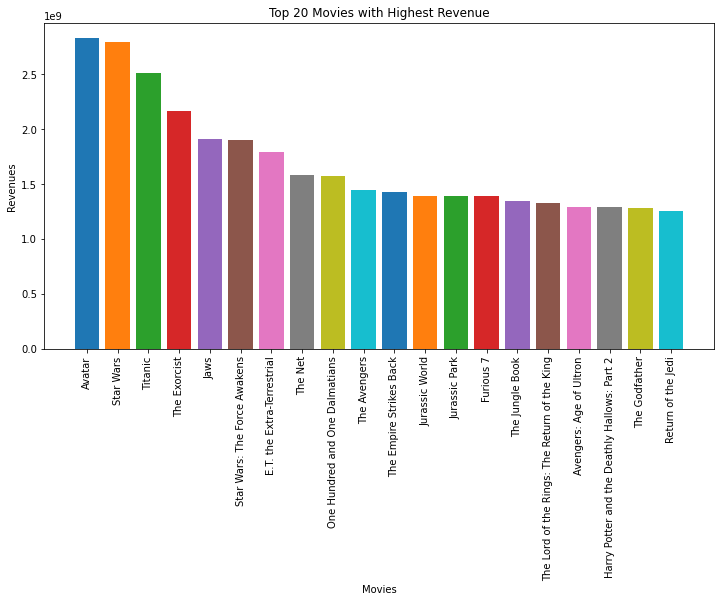

In [72]:
df_r_20 = df.sort_values('revenue', ascending=False).head(20)
plt.figure(figsize=(12, 6))
plt.bar(df_r_20.title, df_r_20.revenue, color=std_colors)
plt.title('Top 20 Movies with Highest Revenue')
plt.xlabel('Movies')
plt.xticks(rotation=90)
plt.ylabel('Revenues');

> **Avatar** seems to be toping the list with a revenue of about `$2.8e9` followed closely by **Star Wars**. The last on the list is **Return of the Jedi** (Part of Star Wars).
>
> Let's look at what `genre` is most prominant in this list.

#### Most prominent `genres` in top 20 list
> Will be expanding the genre column since they are concatenated.

In [73]:
df_r_20_expanded_g = split_column(df_r_20, 'genres', '|')
df_r_20_expanded_g.shape

(65, 15)

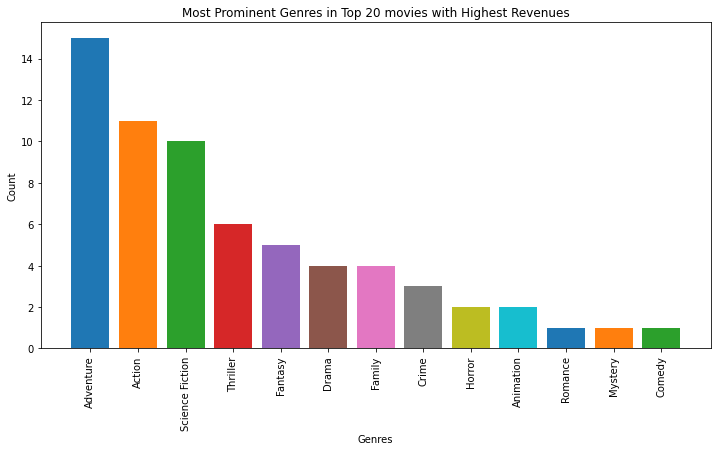

In [74]:
plt.figure(figsize=(12, 6))
plt.bar(df_r_20_expanded_g.genres.value_counts().index, df_r_20_expanded_g.genres.value_counts(), color=std_colors)
plt.title('Most Prominent Genres in Top 20 movies with Highest Revenues')
plt.xlabel('Genres')
plt.xticks(rotation=90)
plt.ylabel('Count');

> **Adventure** leading in about `15` of the `20` movies followed closely by **Action** in about `11` of the `20` movies. And then **Science Fiction**, **Thriller** ...
>
> Let's try to see which of the top 20 movies had actual profits.

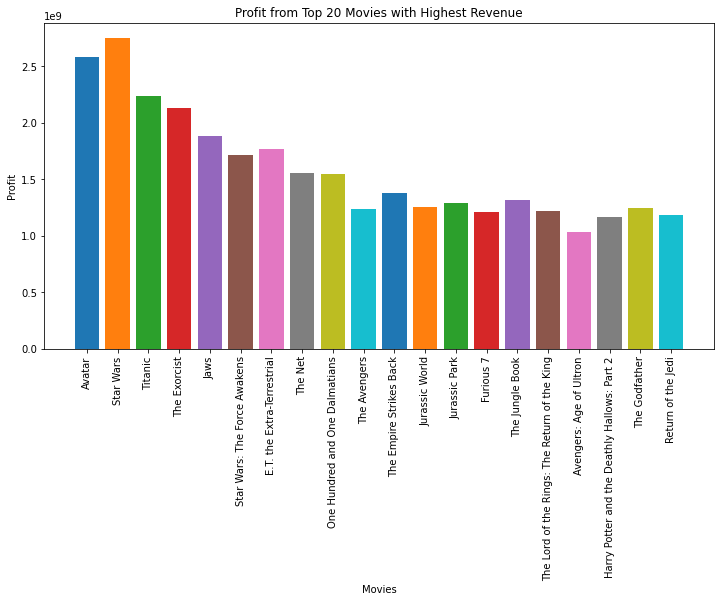

In [75]:
plt.figure(figsize=(12, 6))
plt.bar(df_r_20.title, df_r_20.profit, color=std_colors)
plt.title('Profit from Top 20 Movies with Highest Revenue')
plt.xlabel('Movies')
plt.xticks(rotation=90)
plt.ylabel('Profit');

> Seems the trend is about consistent with the `revenue` for this top 20 list. While studying the dataset, I saw that movies in the genre where action figures and toys can be made from mostly genrate more profit than others. 
>
> Let's see the genres for a couplte of this movies

In [77]:
df_r_20[['title', 'genres', 'release_year']].head(10)

,title,genres,release_year
1386,Avatar,Action|Adventure|Fantasy|Science Fiction,2009
1329,Star Wars,Adventure|Action|Science Fiction,1977
5231,Titanic,Drama|Romance|Thriller,1997
10594,The Exorcist,Drama|Horror|Thriller,1973
9806,Jaws,Horror|Thriller|Adventure,1975
3,Star Wars: The Force Awakens,Action|Adventure|Science Fiction|Fantasy,2015
8889,E.T. the Extra-Terrestrial,Science Fiction|Adventure|Family|Fantasy,1982
8094,The Net,Crime|Drama|Mystery|Thriller|Action,1995
10110,One Hundred and One Dalmatians,Adventure|Animation|Comedy|Family,1961
4361,The Avengers,Science Fiction|Action|Adventure,2012


> Looked at the top 5 on the list and seems action figures can be made for just about anything. However, I couldn't find action figures for **The Net** and it maintained the same profit status with **One Hundred and One Dalmatians** with soo many.  Possibly action figure sales might be a mojor revenue stream. Release years doesn't seem to influence revenue so much
>
> Generally movies with high revenue general make high profit (common sense😂).
>
> Maybe we should look at the revenue to expense ratio. 

#### Looking at top 20 movies based on revenue to budget ratio

In [83]:
df['rb_ratio'] = df.revenue / df.budget
df.head(1)

,id,popularity,title,cast,director,runtime,genres,production_companies,release_date,rate_count,rating,release_year,budget,revenue,profit,rb_ratio
0,135397,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09,10.090192


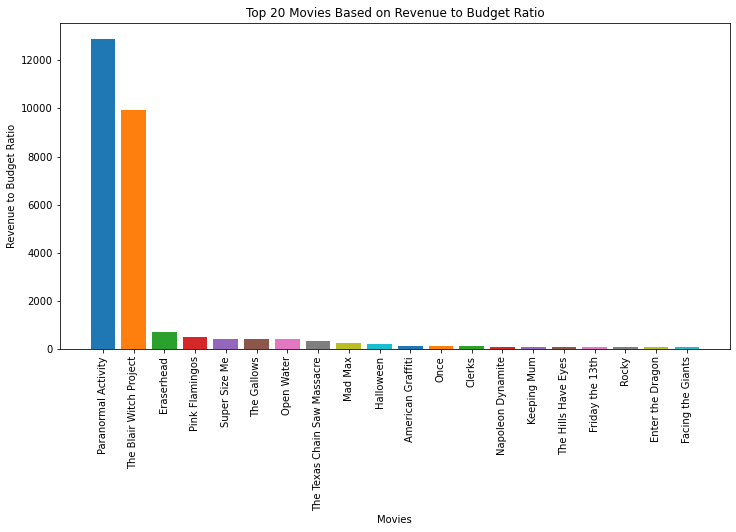

In [84]:
top_20_rb_ratio = df.sort_values('rb_ratio', ascending=False).head(20)
plt.figure(figsize=(12, 6))
plt.bar(top_20_rb_ratio.title, top_20_rb_ratio.rb_ratio, color=std_colors)
plt.title('Top 20 Movies Based on Revenue to Budget Ratio')
plt.xlabel('Movies')
plt.xticks(rotation=90)
plt.ylabel('Revenue to Budget Ratio');

> Hmmm... Seems our big bucks movies didn't make it to this list. Let's see what `genres` are most prominent in this list.

#### Most prominent `genres` in Top 20 Movies Based on Revenue to Budget Ratio

In [89]:
top_20_rb_ratio_exp_g = split_column(top_20_rb_ratio, 'genres', '|')
top_20_rb_ratio_exp_g.shape

(39, 16)

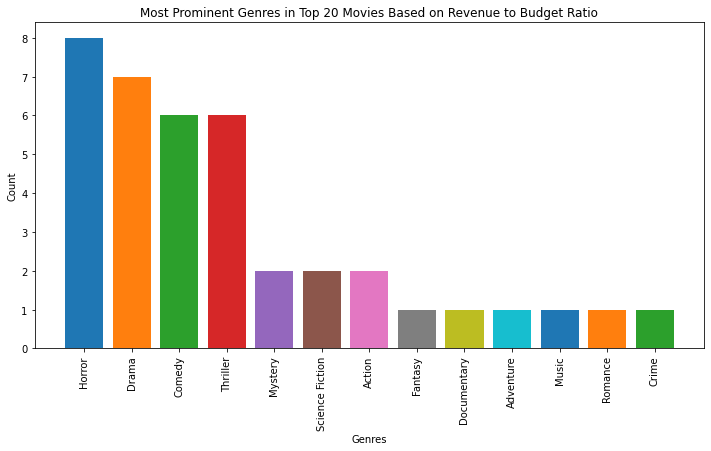

In [90]:
plt.figure(figsize=(12, 6))
plt.bar(top_20_rb_ratio_exp_g.genres.value_counts().index, top_20_rb_ratio_exp_g.genres.value_counts(), color=std_colors)
plt.title('Most Prominent Genres in Top 20 Movies Based on Revenue to Budget Ratio')
plt.xlabel('Genres')
plt.xticks(rotation=90)
plt.ylabel('Count');

> Hmmm... Looking to make substantial profit with low investment then you should look at making movies in `genres` **Horror**, **Drama**, **Comedy**, **Thriller**...
>
> Let's how this group profit compares with our highest revenue movies group

<BarContainer object of 2 artists>

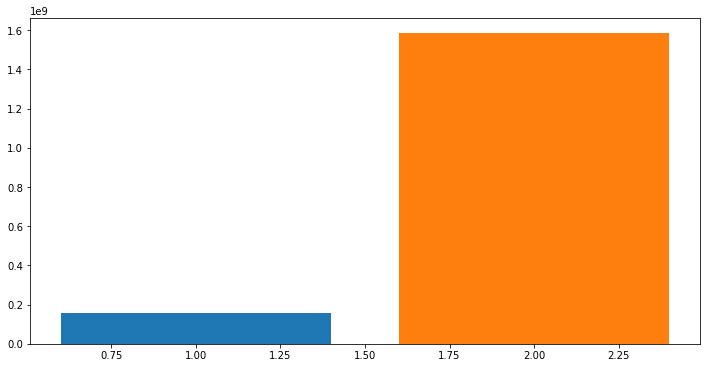

In [93]:
plt.figure(figsize=(12, 6))
plt.bar([1, 2], [top_20_rb_ratio.profit.mean(), df_r_20.profit.mean()], color=std_colors)

### Research Question 2  (Replace this header name!)

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!